In [15]:
!pip install torch torchvision opencv-python numpy pandas
!pip install torch torchvision opencv-python numpy pandas pillow


import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
import os
import zipfile
import tempfile
import shutil

import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



Fold 1 Results:

Epoch 5/10
Train Loss: 0.0001, Val Loss: 0.0005
Pupil MAE: 0.0218
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000

Epoch 10/10
Train Loss: 0.0001, Val Loss: 0.0003
Pupil MAE: 0.0187
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000


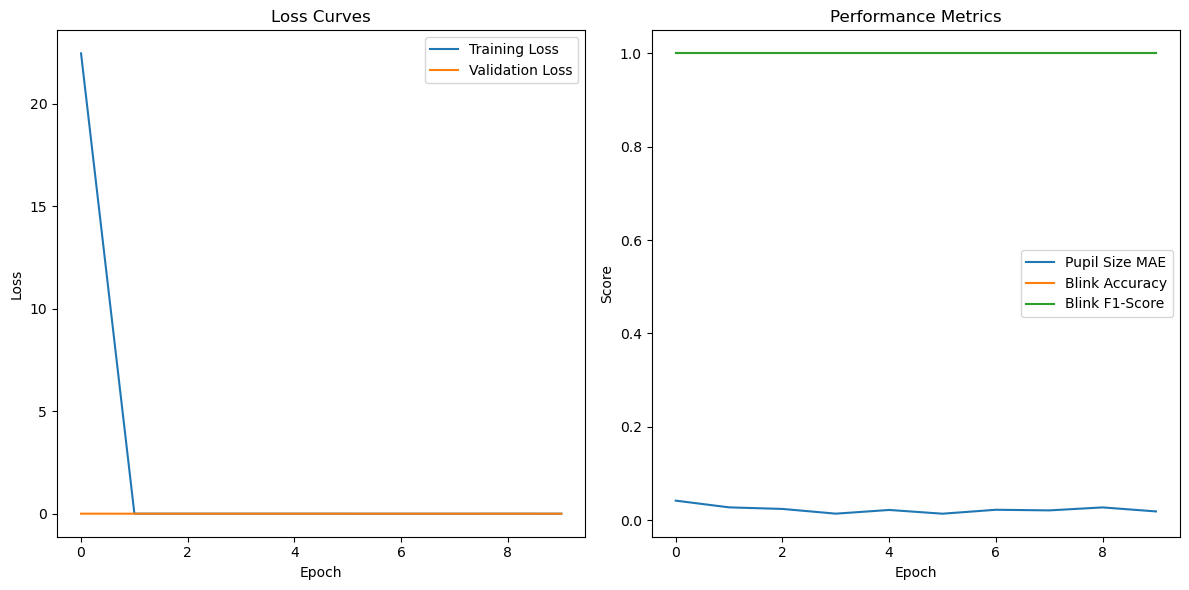

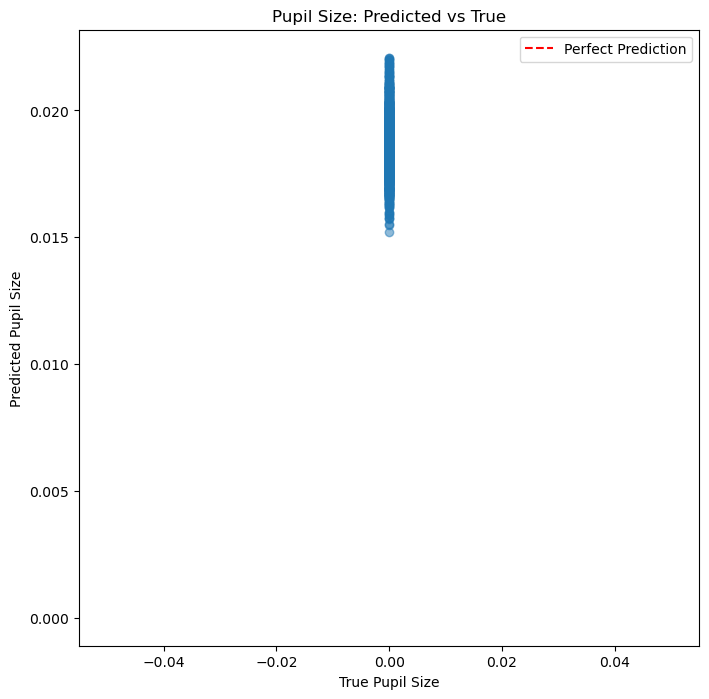


Fold 2 Results:

Epoch 5/10
Train Loss: 0.0001, Val Loss: 0.0003
Pupil MAE: 0.0166
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000

Epoch 10/10
Train Loss: 0.0000, Val Loss: 0.0002
Pupil MAE: 0.0142
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000


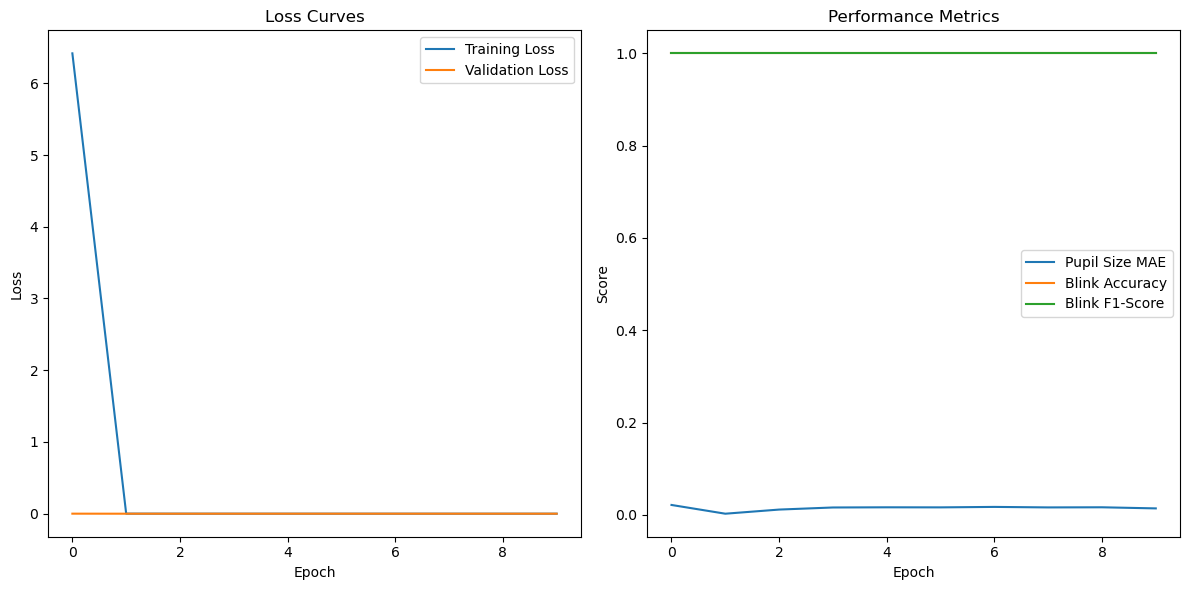

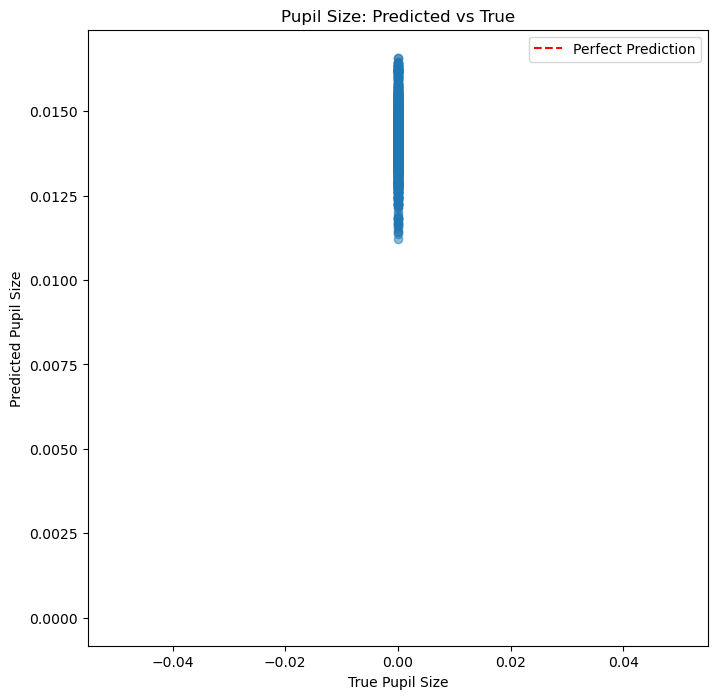


Fold 3 Results:

Epoch 5/10
Train Loss: 0.0001, Val Loss: 0.0000
Pupil MAE: 0.0068
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000

Epoch 10/10
Train Loss: 0.0000, Val Loss: 0.0000
Pupil MAE: 0.0068
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000


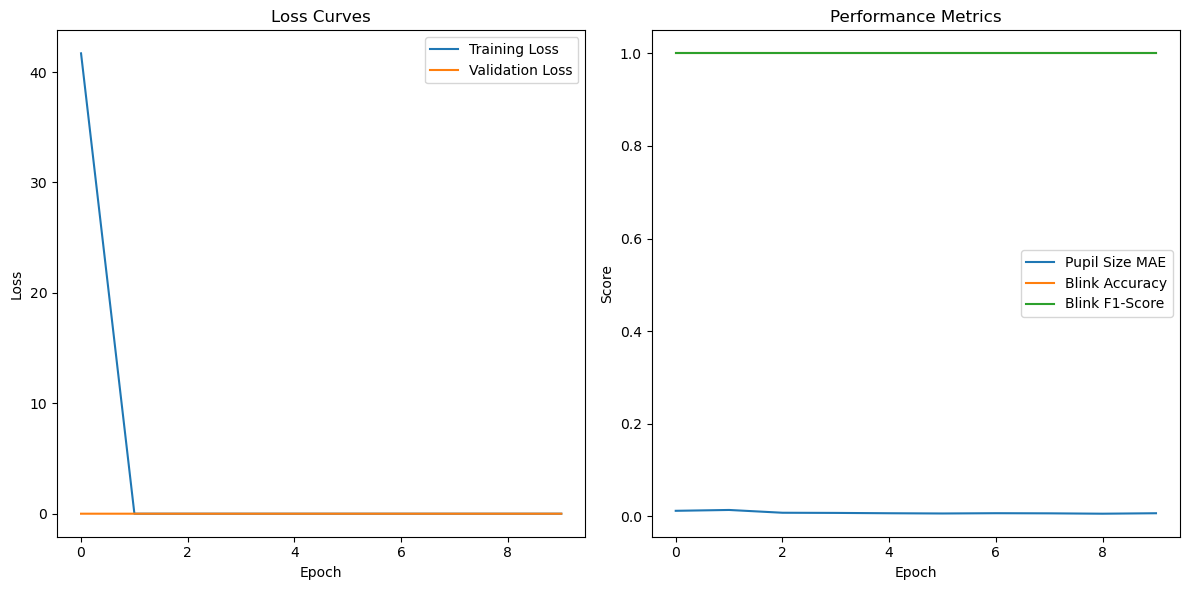

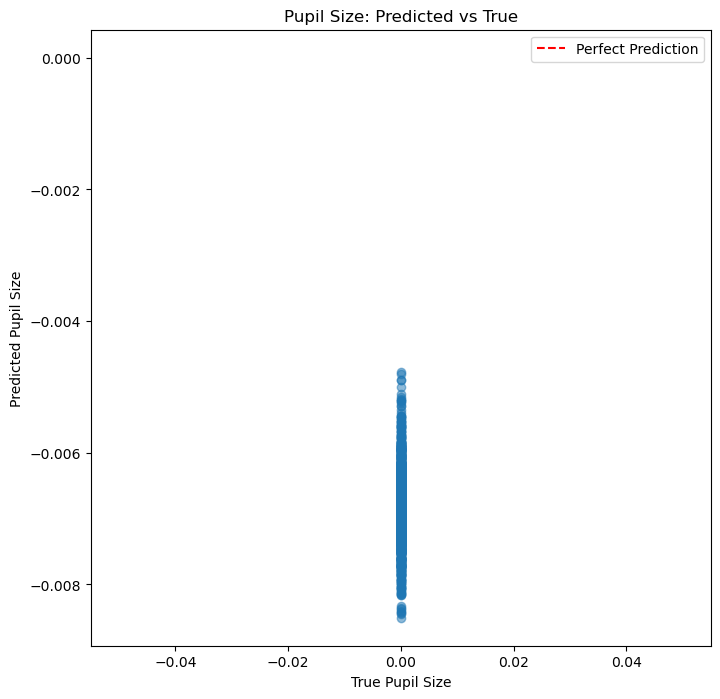


Fold 4 Results:

Epoch 5/10
Train Loss: 0.0001, Val Loss: 0.0002
Pupil MAE: 0.0151
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000

Epoch 10/10
Train Loss: 0.0000, Val Loss: 0.0003
Pupil MAE: 0.0173
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000


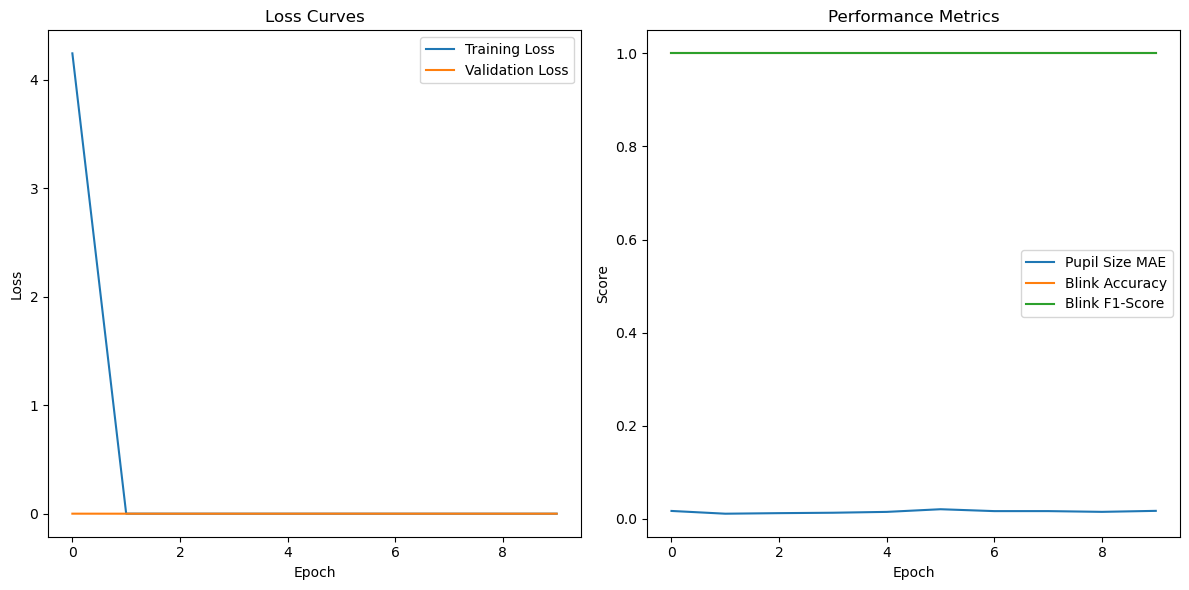

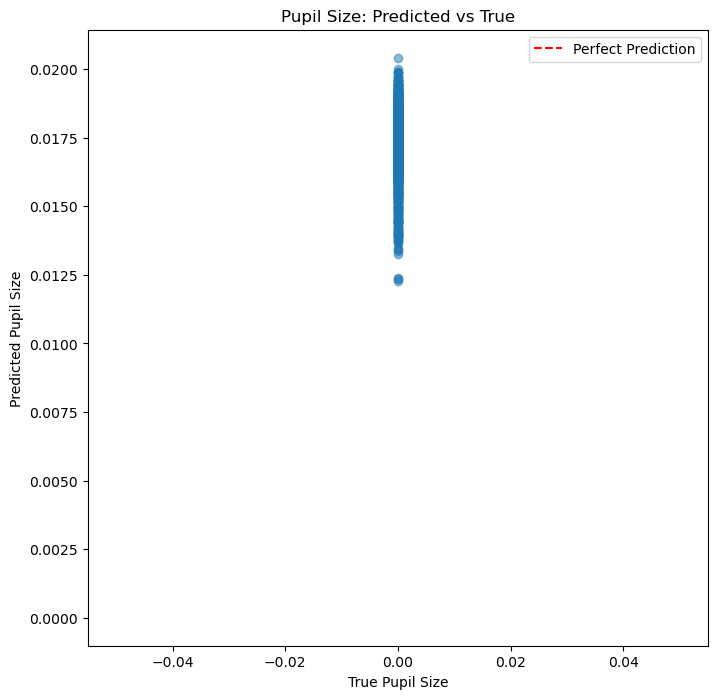


Fold 5 Results:

Epoch 5/10
Train Loss: 0.0001, Val Loss: 0.0000
Pupil MAE: 0.0065
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000

Epoch 10/10
Train Loss: 0.0000, Val Loss: 0.0001
Pupil MAE: 0.0076
Blink Accuracy: 1.0000
Blink F1-Score: 1.0000


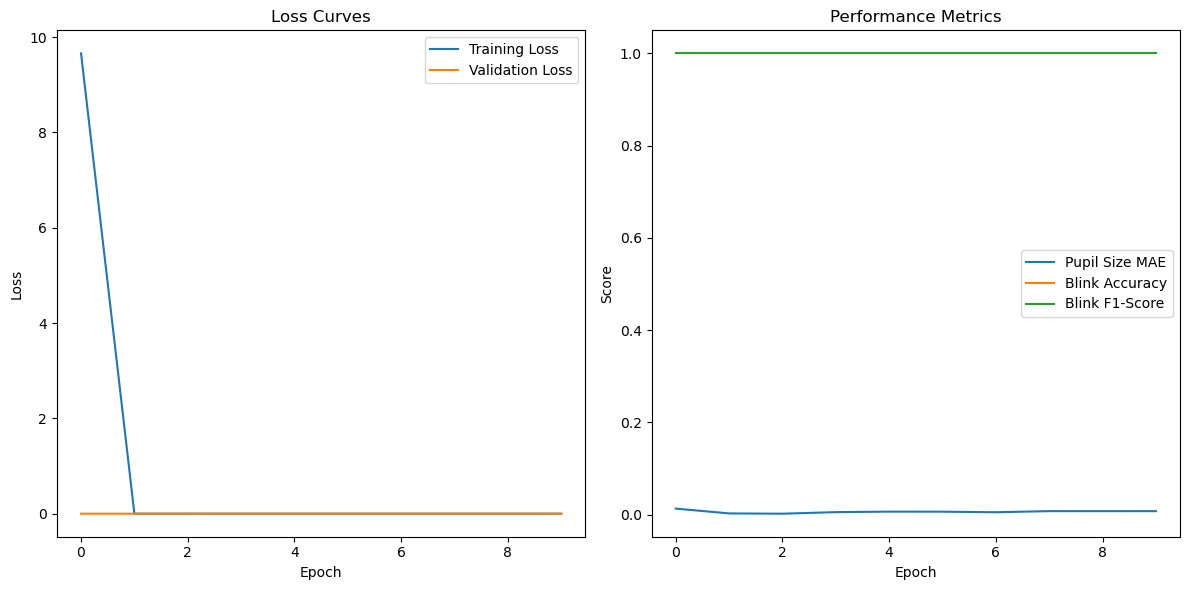

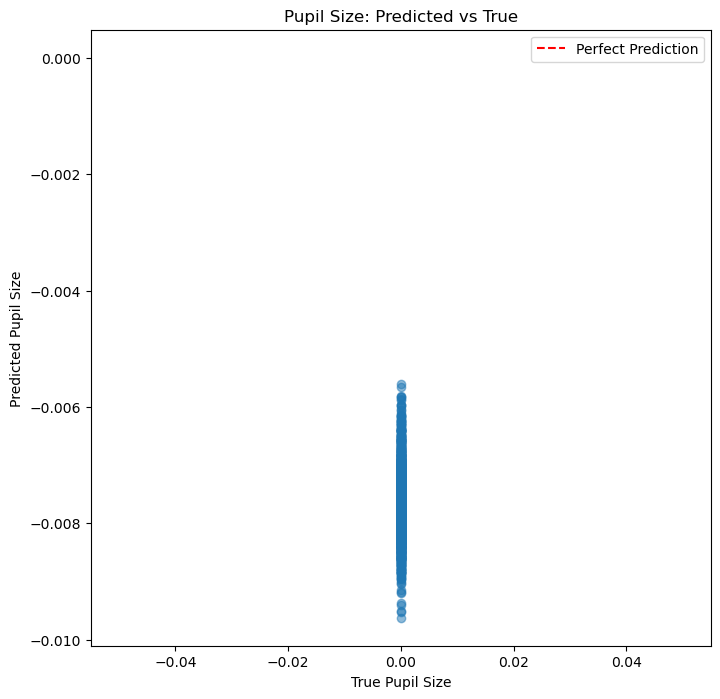


Cross-Validation Average Results:
pupil_mae: 0.0129
blink_accuracy: 1.0000
blink_f1: 1.0000


In [17]:
class PupilDetectionDataset(Dataset):
    def __init__(self, video_zip, annotation_zip, transform=None):
        """
        Custom Dataset for Pupil Detection with zipped video and annotation files
        
        Args:
        - video_zip (str): Path to zip file containing video files
        - annotation_zip (str): Path to zip file containing annotation files
        - transform (callable, optional): Optional transform to be applied on a sample
        """
        # Create temporary directories to extract zip contents
        self.temp_video_dir = tempfile.mkdtemp()
        self.temp_annotation_dir = tempfile.mkdtemp()
        
        try:
            # Extract zip files
            self._extract_zip(video_zip, self.temp_video_dir)
            self._extract_zip(annotation_zip, self.temp_annotation_dir)
            
            # Identify video and annotation files
            self.video_files = sorted([f for f in os.listdir(self.temp_video_dir) if f.endswith('.avi')])
            self.annotation_files = sorted([f for f in os.listdir(self.temp_annotation_dir) if f.endswith('.txt')])
            
            # Validate file matching
            assert len(self.video_files) == len(self.annotation_files), \
                "Number of video and annotation files must match"
            
            # Transform
            self.transform = transform
            
            # Preprocess and extract frames with annotations
            self.data = self._extract_frames_and_annotations()
        
        except Exception as e:
            # Cleanup temp directories in case of error
            self._cleanup()
            raise e
    
    def _extract_zip(self, zip_path, extract_path):
        """
        Extract zip file to specified path
        
        Args:
        - zip_path (str): Path to the zip file
        - extract_path (str): Path to extract the contents
        """
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    
    def _extract_frames_and_annotations(self):
        """
        Extract frames from videos and corresponding annotations
        
        Returns:
        - List of dictionaries containing frame data and annotations
        """
        all_data = []
        
        for video_file, annotation_file in zip(self.video_files, self.annotation_files):
            video_path = os.path.join(self.temp_video_dir, video_file)
            annotation_path = os.path.join(self.temp_annotation_dir, annotation_file)
            
            # Read annotations
            annotations = self._parse_annotation_file(annotation_path)
            
            # Process video
            cap = cv2.VideoCapture(video_path)
            frame_count = 0
            
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Process every 5th frame
                if frame_count % 5 == 0:
                    # Preprocess frame
                    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    resized_frame = cv2.resize(gray_frame, (128, 128))
                    normalized_frame = cv2.equalizeHist(resized_frame)
                    
                    # Find corresponding annotation
                    frame_annotation = self._get_frame_annotation(annotations, frame_count)
                    
                    all_data.append({
                        'frame': normalized_frame,
                        'pupil_diameter': frame_annotation['diameter'],
                        'blink': frame_annotation['blink'],
                        'squint': frame_annotation['squint']
                    })
                
                frame_count += 1
            
            cap.release()
        
        return all_data
    
    def _parse_annotation_file(self, annotation_path):
        """
        Parse .txt annotation file
        Assumes format: frame_number diameter blink squint
        
        Args:
        - annotation_path (str): Path to annotation .txt file
        
        Returns:
        - List of dictionaries with frame annotations
        """
        annotations = []
        with open(annotation_path, 'r') as f:
            for line in f:
                # Split line and convert to appropriate types
                parts = line.strip().split()
                if len(parts) == 4:
                    annotations.append({
                        'frame': int(parts[0]),
                        'diameter': float(parts[1]),
                        'blink': int(parts[2]),
                        'squint': int(parts[3])
                    })
        return annotations
    
    def _get_frame_annotation(self, annotations, frame_number):
        """
        Find annotation for a specific frame
        
        Args:
        - annotations (list): List of frame annotations
        - frame_number (int): Current frame number
        
        Returns:
        - Dict with frame annotation or default values
        """
        for annotation in annotations:
            if annotation['frame'] == frame_number:
                return annotation
        
        # Default values if no annotation found
        return {
            'diameter': 0.0,  # Neutral pupil diameter
            'blink': 0,       # Not blinking
            'squint': 0       # Not squinting
        }
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Convert to tensors
        frame_tensor = torch.from_numpy(item['frame']).float().unsqueeze(0)
        
        return frame_tensor, {
            'pupil_size': torch.tensor(item['pupil_diameter'], dtype=torch.float32).unsqueeze(0),
            'blink': torch.tensor(item['blink'], dtype=torch.long),
            'squint': torch.tensor(item['squint'], dtype=torch.long)
        }
    
    def __del__(self):
        """
        Cleanup temporary directories when dataset is deleted
        """
        self._cleanup()
    
    def _cleanup(self):
        """
        Remove temporary directories
        """
        if hasattr(self, 'temp_video_dir'):
            shutil.rmtree(self.temp_video_dir, ignore_errors=True)
        if hasattr(self, 'temp_annotation_dir'):
            shutil.rmtree(self.temp_annotation_dir, ignore_errors=True)

class PupilDetectionCNN(nn.Module):
    def __init__(self):
        super(PupilDetectionCNN, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Calculate the size of flattened features
        self.flatten_size = 256 * 8 * 8  # For 128x128 input
        
        # Common fully connected layers
        self.fc_common = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Specific heads for each task
        # Pupil size regression
        self.pupil_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        # Blink classification
        self.blink_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Binary classification
        )
        
        # Squint classification
        self.squint_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Binary classification
        )
    
    def forward(self, x):
        # Feature extraction
        x = self.conv_layers(x)
        x = x.view(-1, self.flatten_size)
        
        # Common features
        features = self.fc_common(x)
        
        # Task-specific predictions
        return {
            'pupil_size': self.pupil_head(features),
            'blink': self.blink_head(features),
            'squint': self.squint_head(features)
        }



class TrainingVisualizer:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.pupil_maes = []
        self.blink_accuracies = []
        self.blink_f1_scores = []
        
    def update_metrics(self, train_loss: float, val_loss: float, 
                      pupil_mae: float, blink_acc: float, blink_f1: float):
        """Update tracking metrics with new values"""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.pupil_maes.append(pupil_mae)
        self.blink_accuracies.append(blink_acc)
        self.blink_f1_scores.append(blink_f1)
    
    def plot_training_curves(self, save_path: str = None):
        """Plot training and validation loss curves"""
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.pupil_maes, label='Pupil Size MAE')
        plt.plot(self.blink_accuracies, label='Blink Accuracy')
        plt.plot(self.blink_f1_scores, label='Blink F1-Score')
        plt.title('Performance Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()
    
    def plot_pupil_size_correlation(self, true_sizes: np.ndarray, 
                                  pred_sizes: np.ndarray, 
                                  save_path: str = None):
        """Plot correlation between predicted and true pupil sizes"""
        plt.figure(figsize=(8, 8))
        plt.scatter(true_sizes, pred_sizes, alpha=0.5)
        plt.plot([min(true_sizes), max(true_sizes)], 
                [min(true_sizes), max(true_sizes)], 
                'r--', label='Perfect Prediction')
        plt.xlabel('True Pupil Size')
        plt.ylabel('Predicted Pupil Size')
        plt.title('Pupil Size: Predicted vs True')
        plt.legend()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Add the evaluate_model function here
def evaluate_model(model: torch.nn.Module, 
                  data_loader: torch.utils.data.DataLoader) -> Tuple[Dict, List, List]:
    """
    Evaluate model performance and collect predictions
    
    Returns:
        metrics_dict: Dictionary containing performance metrics
        true_pupil_sizes: List of true pupil sizes
        pred_pupil_sizes: List of predicted pupil sizes
    """
    model.eval()
    true_pupil_sizes = []
    pred_pupil_sizes = []
    true_blinks = []
    pred_blinks = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            
            # Collect pupil size predictions
            true_pupil_sizes.extend(targets['pupil_size'].numpy().flatten())
            pred_pupil_sizes.extend(outputs['pupil_size'].numpy().flatten())
            
            # Collect blink predictions
            true_blinks.extend(targets['blink'].numpy())
            pred_blinks.extend(torch.argmax(outputs['blink'], dim=1).numpy())
    
    # Calculate metrics
    metrics = {
        'pupil_mae': mean_absolute_error(true_pupil_sizes, pred_pupil_sizes),
        'blink_accuracy': accuracy_score(true_blinks, pred_blinks),
        'blink_f1': f1_score(true_blinks, pred_blinks, average='weighted')
    }
    
    return metrics, true_pupil_sizes, pred_pupil_sizes

# Replace the existing train_and_evaluate function with this updated version
def train_and_evaluate(model: torch.nn.Module, 
                      train_loader: torch.utils.data.DataLoader,
                      val_loader: torch.utils.data.DataLoader,
                      num_epochs: int = 10) -> Dict:
    """
    Train the model and track metrics
    
    Returns:
        Dict containing final performance metrics
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion_reg = torch.nn.MSELoss()  # For pupil size
    criterion_clf = torch.nn.CrossEntropyLoss()  # For blink/squint
    
    visualizer = TrainingVisualizer()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Calculate losses
            loss_pupil = criterion_reg(outputs['pupil_size'], targets['pupil_size'])
            loss_blink = criterion_clf(outputs['blink'], targets['blink'])
            loss_squint = criterion_clf(outputs['squint'], targets['squint'])
            
            total_loss = loss_pupil + loss_blink + loss_squint
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                
                # Calculate validation losses
                loss_pupil = criterion_reg(outputs['pupil_size'], targets['pupil_size'])
                loss_blink = criterion_clf(outputs['blink'], targets['blink'])
                loss_squint = criterion_clf(outputs['squint'], targets['squint'])
                
                val_loss += (loss_pupil + loss_blink + loss_squint).item()
        
        val_loss /= len(val_loader)
        
        # Evaluate metrics
        val_metrics, true_sizes, pred_sizes = evaluate_model(model, val_loader)
        
        # Update visualizer
        visualizer.update_metrics(
            train_loss, 
            val_loss,
            val_metrics['pupil_mae'],
            val_metrics['blink_accuracy'],
            val_metrics['blink_f1']
        )
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"Pupil MAE: {val_metrics['pupil_mae']:.4f}")
            print(f"Blink Accuracy: {val_metrics['blink_accuracy']:.4f}")
            print(f"Blink F1-Score: {val_metrics['blink_f1']:.4f}")
    
    # Plot final results
    visualizer.plot_training_curves(save_path='training_curves.png')
    visualizer.plot_pupil_size_correlation(
        np.array(true_sizes), 
        np.array(pred_sizes),
        save_path='pupil_correlation.png'
    )
    
    return val_metrics

# Update the main function
def main():
    # Paths to zip files
    video_zip = 'VID.zip'    # Zip file containing video files
    annotation_zip = 'ANN.zip'  # Zip file containing annotation files
    
    # Create dataset
    full_dataset = PupilDetectionDataset(video_zip, annotation_zip)
    
    # Prepare data loaders with k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Collect cross-validation results
    cv_results = []
    
    # Stratified k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(full_dataset, 
        [item['blink'] for item in full_dataset.data]), 1):
        
        # Create subset of data for this fold
        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_dataset, val_idx)
        
        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32)
        
        # Initialize model for each fold
        model = PupilDetectionCNN()
        
        # Train and evaluate
        print(f"\nFold {fold} Results:")
        fold_results = train_and_evaluate(model, train_loader, val_loader, num_epochs=10)
        cv_results.append(fold_results)
    
    # Aggregate cross-validation results
    avg_results = {}
    for metric in cv_results[0].keys():
        avg_results[metric] = np.mean([fold[metric] for fold in cv_results])
    
    print("\nCross-Validation Average Results:")
    for metric, value in avg_results.items():
        print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()
